In [160]:
import numpy as np
import os
import glob
import scipy.ndimage as ndimage
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from skimage import feature
import skimage
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

# Final current thoughts
# Smears are heavily over-emphasized
# My soph idea seems to work well, but

In [172]:
# Load all the images up
# Kindly note, ROC curve can also be used for finding thresholding params.
# Play with filter sizes
# More investigation better.
directory_path = './data/cells'
image_files = [f for f in glob.glob(os.path.join(directory_path, '*')) if 'Edges' not in os.path.basename(f)]
images = np.array([np.array(Image.open(filename).convert('L'), dtype=np.float32) for filename in image_files])

ground_truth_image_files = [f for f in glob.glob(os.path.join(directory_path, '*')) if 'Edges' in os.path.basename(f)]
ground_truths = np.array([np.array(Image.open(filename).convert('L'), dtype=np.float32) for filename in ground_truth_image_files])

In [4]:
def perc(percentile,img):
    flat_gray = img.flatten()
    threshold = np.percentile(flat_gray, percentile)
    max_brightness_mask = np.where(img > threshold, 255, img)
    return max_brightness_mask

In [284]:
def process_images(images, edge_type, apply_blur_gauss=False, blur_sigma=0, thresholding = False, lksize = 3, threshold = 0):
    
    def variance_threshold(src, edges, threshold):
        win_mean = ndimage.uniform_filter(src, (5, 5))
        win_sqr_mean = ndimage.uniform_filter(src**2, (5, 5))
        win_var = win_sqr_mean - win_mean**2
        print(np.max(win_var))
        low_variance_mask = win_var < threshold
        edges = np.where(low_variance_mask, 0, edges)
        return edges

    processed_images = []

    # Unsigned 8-bit integer, this is perfect.
    kdepth = cv.CV_8U
    
    for img in images:
        edges = None
        
        if apply_blur_gauss:
            img = ndimage.gaussian_filter(img, blur_sigma)

        if edge_type == "Roberts":
            gx_mask = np.array([[1, 0 ], [0,-1 ]])
            gy_mask = np.array([[ 0, 1 ], [ -1, 0 ]])

            vertical = ndimage.convolve(img, gx_mask)
            horizontal = ndimage.convolve(img, gy_mask)

            edges = (np.abs(horizontal) + np.abs(vertical))

        if edge_type == "Sobel":

            scale = 1
            delta = 0

            grad_x = cv.Sobel(img, kdepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)    
            grad_y = cv.Sobel(img, kdepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)

            abs_grad_x = cv.convertScaleAbs(grad_x)
            abs_grad_y = cv.convertScaleAbs(grad_y)

            edges = (np.abs(abs_grad_x) + np.abs(abs_grad_y))

        if edge_type == "First Order Gaussian":
            
            gx_mask = np.array([[-1, 1 ], [-1, 1]])
            gy_mask = np.array([[ 1, 1 ], [ -1, -1 ]])

            img = cv.GaussianBlur(img, (3, 3), 0)

            vertical = ndimage.convolve(img, gx_mask)
            horizontal = ndimage.convolve(img, gy_mask)
            
            edges = (np.abs(horizontal) + np.abs(vertical))

        if edge_type == "Laplacian":
            edges = skimage.filters.laplace(image=img)

        if edge_type == "Laplacian of Gaussian":
            edges = ndimage.gaussian_laplace(img, 10)

        if edge_type == "Canny":
            low_thresh = threshold/2
            edges = feature.canny(img, sigma=2, low_threshold=low_thresh, high_threshold=threshold)

        if edge_type == "Laplacian" or edge_type == "Laplacian of Gaussian":
            # Zero-crossing operation
            edges = np.pad(edges, ((0, 1), (0, 1)))
            diff_x = edges[:-1, :-1] - edges[:-1, 1:] < 0
            diff_y = edges[:-1, :-1] - edges[1:, :-1] < 0

            edges =  np.logical_or(diff_x, diff_y).astype(float)
            #print(np.unique(edges))

        if thresholding and (edge_type != 'Laplacian' and edge_type != 'Laplacian of Gaussian'):
            high_thresh = threshold
            _,edges = cv.threshold(edges,high_thresh,255,cv.THRESH_BINARY)

        if (edge_type == 'Laplacian' or edge_type == 'Laplacian of Gaussian'):
            if thresholding:
                edges = variance_threshold(img, edges, threshold)
            # Manually convert to uint, things get freaky if you don't.
            edges = (edges * 255).astype(np.uint8)

        edges = np.asarray(edges, dtype=np.uint8)
        edges = ~edges
        processed_images.append(edges)
    
    return np.asarray(processed_images, dtype=np.uint8)

In [61]:
def generate_roc_curve(ground_truths, edge_detected_images):
    flattened_ground_truths = ground_truths.flatten()
    flattened_edge_detected = edge_detected_images.flatten()
    
    # Ensure binary representation (especially if using 255 for edges)
    flattened_ground_truths = (flattened_ground_truths > 0).astype(int)
    flattened_edge_detected = (flattened_edge_detected > 0).astype(int)

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(flattened_ground_truths, flattened_edge_detected)
    roc_auc = auc(fpr, tpr)
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(flattened_ground_truths, flattened_edge_detected)
    
    # Calculate F1 score
    f1 = f1_score(flattened_ground_truths, flattened_edge_detected)

    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
    # Subplot 2: Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    output_description = (
        f'Area Under the ROC Curve (AUC): {roc_auc:.4f}\n'
        f'Precision Scores (at different thresholds): {precision}\n'
        f'Recall Scores (at different thresholds): {recall}\n'
        f'F1 Score: {f1:.4f}'
    )

    print(output_description)

    plt.show()

    return roc_auc, precision, recall, f1

In [227]:
def display_processed_images(processed_images):
    n = len(processed_images)
    cols = 3
    rows = n // cols + (1 if n % cols else 0)
    
    plt.figure(figsize=(15, rows * 5)) 
    
    for i, image in enumerate(processed_images, start=1):
        plt.subplot(rows, cols, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

1515.7661
1511.1772
603.9618


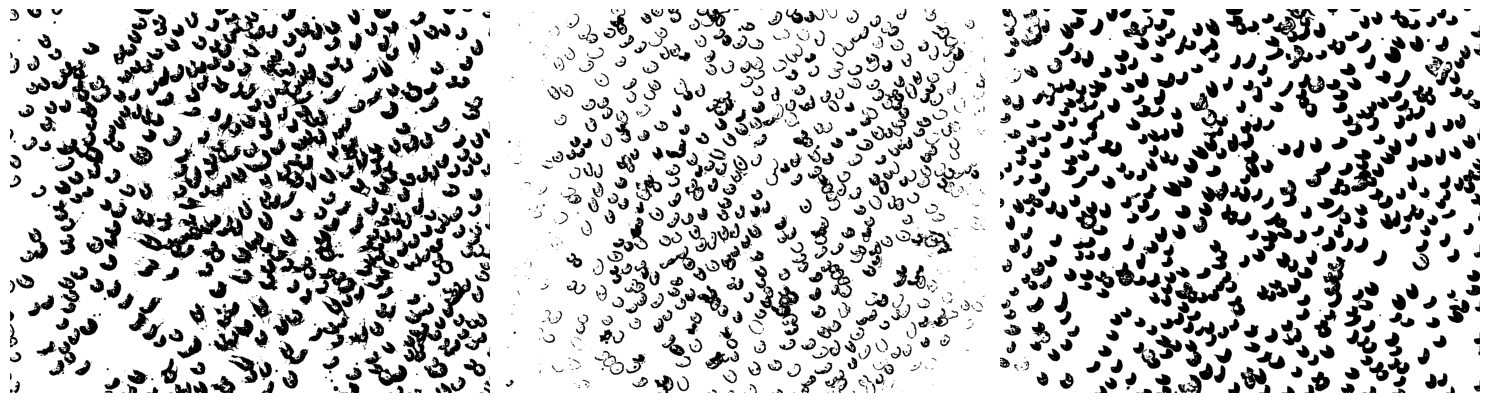

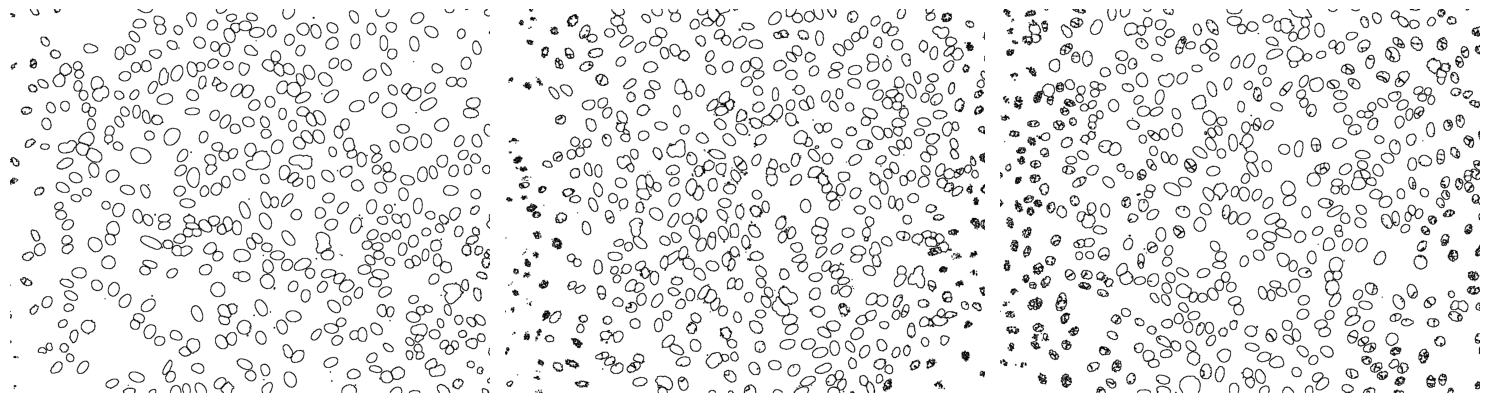

In [293]:
processed_images = process_images(images=images, edge_type="Laplacian of Gaussian", apply_blur_gauss=False, 
                                  blur_sigma=1, thresholding=True, lksize= 3, threshold=10)
display_processed_images(processed_images=processed_images)
display_processed_images(processed_images=ground_truths)

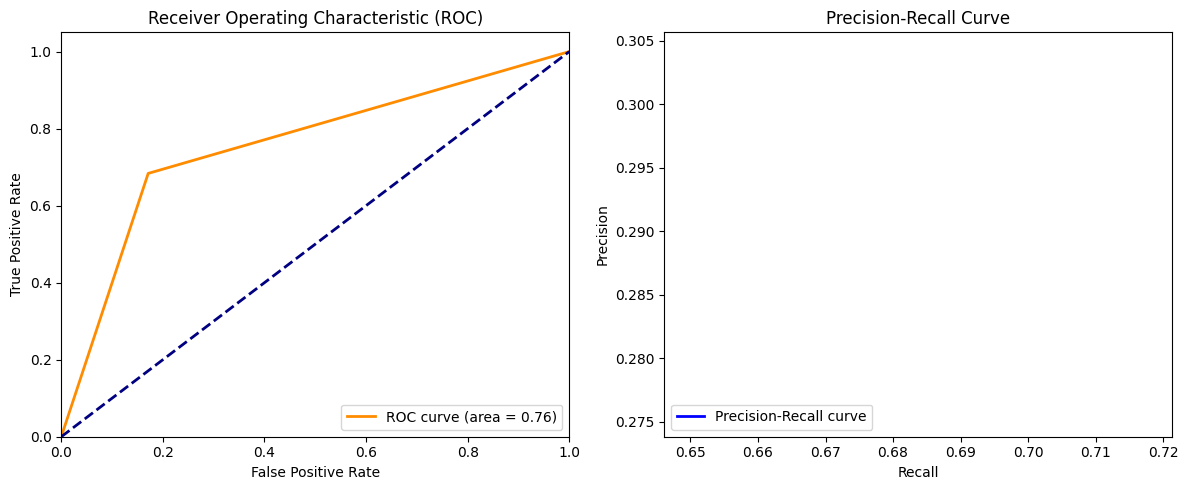

(0.7562885460546674,
 0.28974529599132604,
 0.6836944497058638,
 0.4070046483581221)

In [294]:
generate_roc_curve(ground_truths=ground_truths, edge_detected_images=processed_images)

In [105]:
def generate_roc_curve(ground_truths, edge_detected_images):
    flattened_ground_truths = ground_truths.flatten()
    flattened_edge_detected = edge_detected_images.flatten()

    inverted_flattened_ground_truths = (flattened_ground_truths == 0).astype(int)
    inverted_flattened_edge_detected = (flattened_edge_detected == 0).astype(int)

    tn, fp, fn, tp = confusion_matrix(inverted_flattened_ground_truths, inverted_flattened_edge_detected).ravel()
    
    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate ROC curve and AUC using inverted values
    fpr, tpr, thresholds = roc_curve(inverted_flattened_ground_truths, inverted_flattened_edge_detected)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
    # Subplot 2: Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

    return roc_auc, precision, recall, f1

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


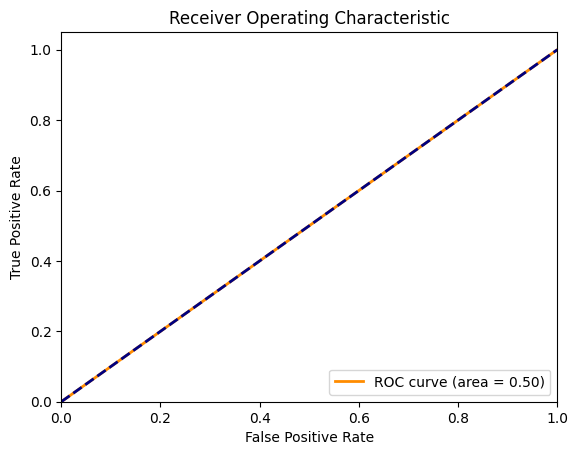

In [223]:
def calc_tpr_fpr(ground_truth, predictions):

    flattened_ground_truths = ground_truth.flatten()
    flattened_edge_detected = predictions.flatten()

    inverted_flattened_ground_truths = (flattened_ground_truths == 0).astype(int)
    inverted_flattened_edge_detected = (flattened_edge_detected == 0).astype(int)

    tn, fp, fn, tp = confusion_matrix(inverted_flattened_ground_truths, inverted_flattened_edge_detected).ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    return tpr, fpr

ground_truth_binary = np.array(ground_truths).astype(int).flatten()


percentiles = [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 255]

tprs = []
fprs = []

for percentile in percentiles:
    
    processed_images = process_images(images=images, edge_type="Laplacian of Gaussian", apply_blur_gauss=False, 
                                  blur_sigma=1, thresholding=True, lksize= 3, histogram_equaltization=False, soph=False, threshold=10)
    
    predictions_flat = processed_images.flatten()
    
    tpr, fpr = calc_tpr_fpr(ground_truth_binary, predictions_flat)
    tprs.append(tpr)
    fprs.append(fpr)

if 0 not in fprs:
    fprs = np.append(fprs, 0)
    tprs = np.append(tprs, 0)

if 1 not in fprs:
    fprs = np.insert(fprs, 0, 1)
    tprs = np.insert(tprs, 0, 1)

#fprs = np.sort(np.unique(fprs))
#tprs = np.sort(np.unique(tprs))

print(fprs, tprs)
roc_auc = auc(fprs, tprs)

plt.figure()
plt.plot(fprs, tprs, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_histogram(img):
    
    # Check if the image is in grayscale or color
    if len(img.shape) == 2 or img.shape[2] == 1:
        # Image is grayscale
        histogram = cv.calcHist([img], [0], None, [256], [0, 256])
        plt.figure()
        plt.title("Grayscale Histogram")
        plt.xlabel("Intensity Value")
        plt.ylabel("Pixel Count")
        plt.plot(histogram)
        plt.xlim([0, 256])
    else:
        # Image is color
        # Calculate histograms for each channel
        color = ('b', 'g', 'r')
        plt.figure()
        plt.title("Color Histogram")
        plt.xlabel("Intensity Value")
        plt.ylabel("Pixel Count")
        for i, col in enumerate(color):
            histogram = cv.calcHist([img], [i], None, [256], [0, 256])
            plt.plot(histogram, color=col)
            plt.xlim([0, 256])
    
    plt.show()

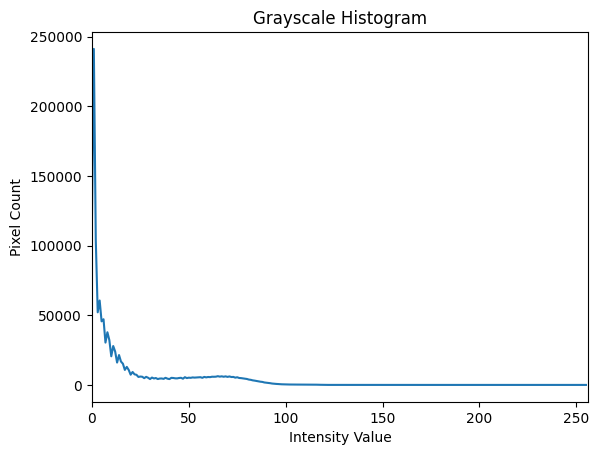

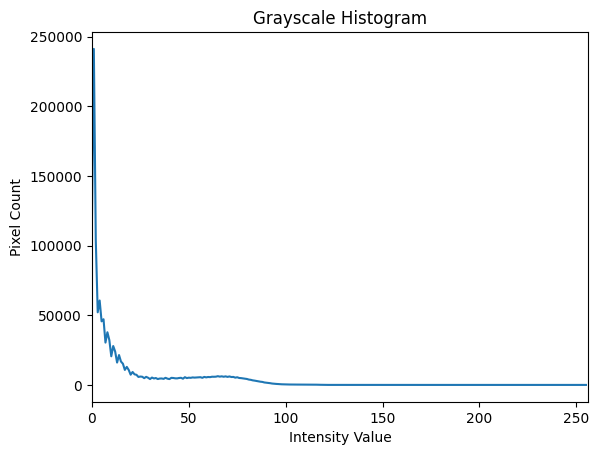

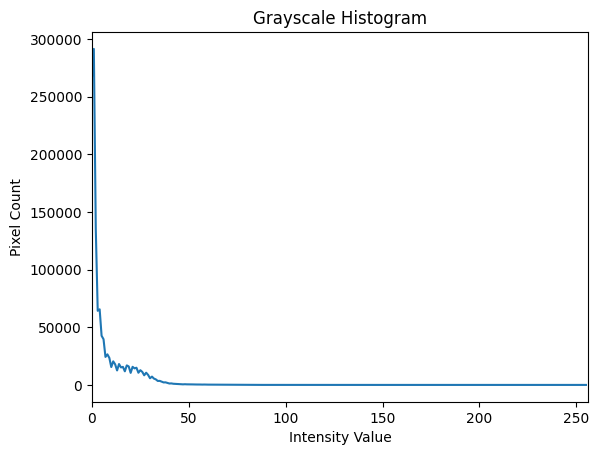

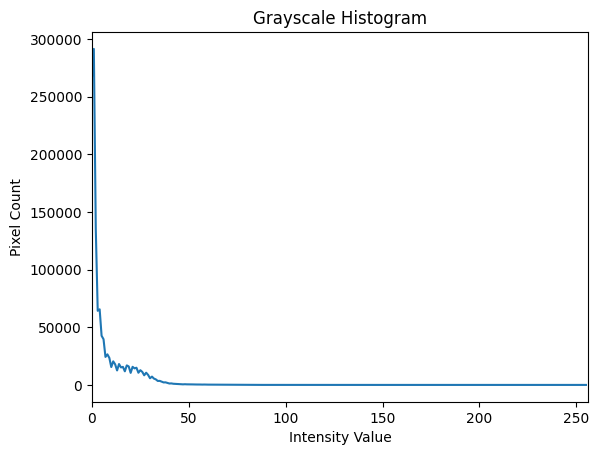

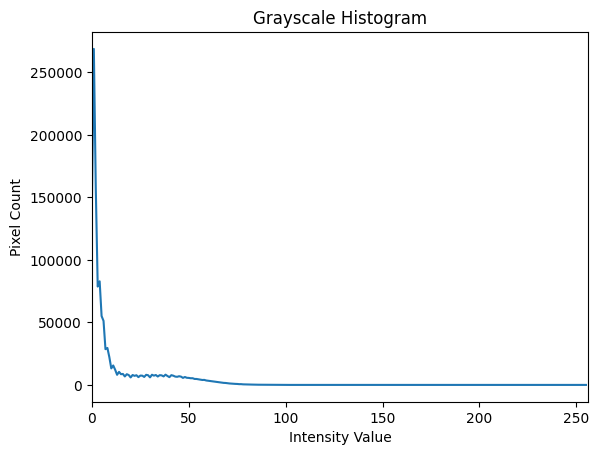

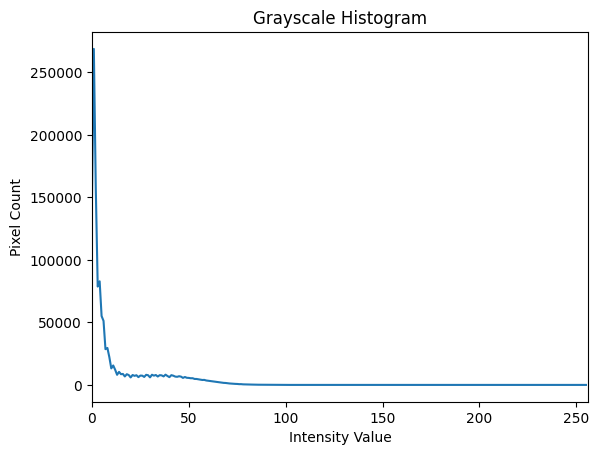

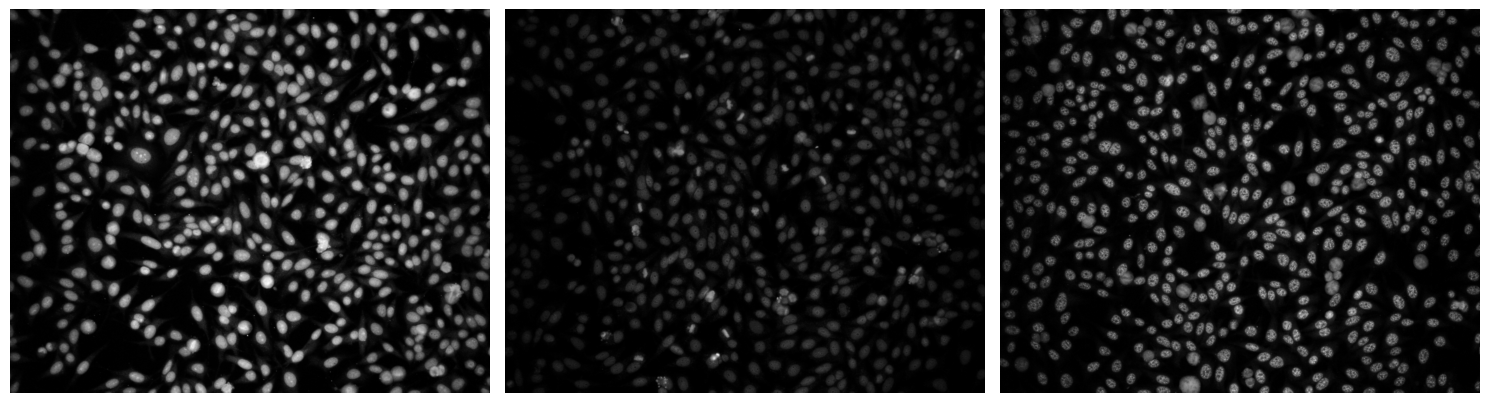

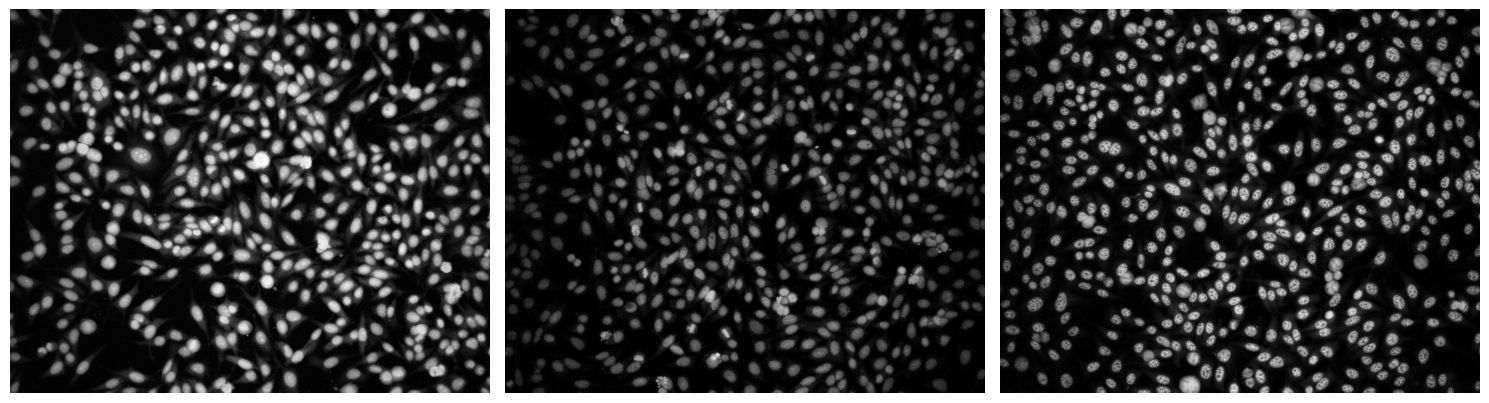

In [ ]:
equalized_images = []

# Histogram Equalization
for img in images:
    plot_histogram(img)
    #img = percentile_max(80, img)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_img = clahe.apply(img)
    equalized_images.append(final_img)
    plot_histogram(img)

display_processed_images(images)
display_processed_images(equalized_images)